In [1]:
import numpy as np
import pandas as pd
from sklearn import svm, neighbors, linear_model, neural_network
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.mixture import GaussianMixture
from sklearn.covariance import GraphicalLasso
from sklearn.svm import SVC, NuSVC
from sklearn.pipeline import Pipeline
from tqdm import tqdm_notebook
import warnings
import multiprocessing
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import manifold
from scipy.optimize import minimize  
warnings.filterwarnings('ignore')

import xgboost as xgb
import artgor_utils


In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
cols = [c for c in train.columns if c not in ['id', 'target', 'wheezy-copper-turtle-magic']]
print(train.shape, test.shape)

(262144, 258) (131073, 257)


In [3]:
def get_mean_cov(x,y):
    model = GraphicalLasso()
    ones = (y==1).astype(bool)
    x2 = x[ones]
    model.fit(x2)
    p1 = model.precision_
    m1 = model.location_
    
    onesb = (y==0).astype(bool)
    x2b = x[onesb]
    model.fit(x2b)
    p2 = model.precision_
    m2 = model.location_
    
    ms = np.stack([m1,m2])
    ps = np.stack([p1,p2])
    return ms,ps

In [4]:
oof_qda = np.zeros(len(train))
oof_mlp = np.zeros(len(train))
oof_gmm = np.zeros(len(train))
oof_svc = np.zeros(len(train))
oof_nusvc = np.zeros(len(train))
oof_knn = np.zeros(len(train))
oof_lr = np.zeros(len(train))

preds_qda = np.zeros(len(test))
preds_mlp = np.zeros(len(test))
preds_gmm = np.zeros(len(test))
preds_svc = np.zeros(len(test))
preds_nusvc = np.zeros(len(test))
preds_knn = np.zeros(len(test))
preds_lr = np.zeros(len(test))

In [5]:
# 512 models
for i in tqdm_notebook(range(512)):

    train2 = train[train['wheezy-copper-turtle-magic'] == i]
    test2 = test[test['wheezy-copper-turtle-magic'] == i]
    idx1 = train2.index
    idx2 = test2.index
    train2.reset_index(drop=True, inplace=True)

    data = pd.concat([pd.DataFrame(train2[cols]), pd.DataFrame(test2[cols])])
    pipe = Pipeline([('vt', VarianceThreshold(threshold=2)),
                     ('scaler', StandardScaler())])
    data2 = pipe.fit_transform(data[cols])
    train3 = data2[:train2.shape[0]]
    test3 = data2[train2.shape[0]:]
    
    skf = StratifiedKFold(n_splits=11, random_state=2019,shuffle=True)
    ###################################################################################################
    #QDA:0.96491

    for train_index, test_index in skf.split(train2, train2['target']):
        qda = QuadraticDiscriminantAnalysis(0.1)
        qda.fit(train3[train_index,:],train2.loc[train_index]['target'])
        oof_qda[idx1[test_index]] = qda.predict_proba(train3[test_index,:])[:,1]
        preds_qda[idx2] += qda.predict_proba(test3)[:,1] / skf.n_splits

    ###################################################################################################
    #MLP:0.914

        mlp = neural_network.MLPClassifier(random_state=3,  activation='relu', solver='lbfgs', tol=1e-06, hidden_layer_sizes=(256, ))
        mlp.fit(train3[train_index,:],train2.loc[train_index]['target'])
        oof_mlp[idx1[test_index]] = mlp.predict_proba(train3[test_index,:])[:,1]
        preds_mlp[idx2] += mlp.predict_proba(test3)[:,1] / skf.n_splits
        
    ###################################################################################################
    #GMM: 0.5 plain, 0.9675 with lasso init

        # MODEL AND PREDICT WITH QDA
        ms, ps = get_mean_cov(train3[train_index,:],train2.loc[train_index]['target'].values)
        
        gmm = GaussianMixture(n_components=2, init_params='random', covariance_type='full', tol=0.001,reg_covar=0.001, max_iter=100, n_init=1,means_init=ms, precisions_init=ps)
        gmm.fit(np.concatenate([train3,test3],axis = 0))
        oof_gmm[idx1[test_index]] = gmm.predict_proba(train3[test_index,:])[:,0]
        preds_gmm[idx2] += gmm.predict_proba(test3)[:,0] / skf.n_splits
    
    ###################################################################################################
    #SVC: 0.94262 ,0.87(3), 0.84(5)

        # MODEL WITH SUPPORT VECTOR MACHINE
        svc = SVC(probability=True,kernel='poly',degree=4,gamma='auto')
        svc.fit(train3[train_index,:],train2.loc[train_index]['target'])
        oof_svc[idx1[test_index]] = svc.predict_proba(train3[test_index,:])[:,1]
        preds_svc[idx2] += svc.predict_proba(test3)[:,1] / skf.n_splits
    
    ###################################################################################################
    #NuSVC: 0.95677, 0.93285(3), 0.93268(5)
        
        nusvc = NuSVC(probability=True, kernel='poly', degree=4, gamma='auto', random_state=4, nu=0.59, coef0=0.053)
        nusvc.fit(train3[train_index,:],train2.loc[train_index]['target'])
        oof_nusvc[idx1[test_index]] = nusvc.predict_proba(train3[test_index,:])[:,1]
        preds_nusvc[idx2] += nusvc.predict_proba(test3)[:,1] / skf.n_splits
    
    ###################################################################################################
    #kNN: 0.91823 (16), 0.91892* (10), 0.91385(6), 0.91721(8)

        knn = neighbors.KNeighborsClassifier(n_neighbors=10, p=2)
        knn.fit(train3[train_index,:],train2.loc[train_index]['target'])
        oof_knn[idx1[test_index]] = knn.predict_proba(train3[test_index,:])[:,1]
        preds_knn[idx2] += knn.predict_proba(test3)[:,1] / skf.n_splits

    ###################################################################################################
    #LR:0.79655

        lr = linear_model.LogisticRegression(solver='saga',penalty='l1',C=0.1)
        lr.fit(train3[train_index,:],train2.loc[train_index]['target'])
        oof_lr[idx1[test_index]] = lr.predict_proba(train3[test_index,:])[:,1]
        preds_lr[idx2] += lr.predict_proba(test3)[:,1] / skf.n_splits

###################################################################################################

In [6]:
print('qda', roc_auc_score(train['target'], oof_qda))
print('mlp', roc_auc_score(train['target'], oof_mlp))
print('gmm', roc_auc_score(train['target'], oof_gmm))
print('svc', roc_auc_score(train['target'], oof_svc))
print('nusvc', roc_auc_score(train['target'], oof_nusvc))
print('knn', roc_auc_score(train['target'], oof_knn))
print('lr', roc_auc_score(train['target'], oof_lr))

qda 0.9649133103878258
mlp 0.9136423018870907
gmm 0.9675109049948782
svc 0.9426015012836912
nusvc 0.9567668612583915
knn 0.9189180115210822
lr 0.7965454512028207


In [7]:
oof_qda = oof_qda.reshape(-1, 1)
preds_qda = preds_qda.reshape(-1, 1)

oof_mlp = oof_mlp.reshape(-1, 1)
preds_mlp = preds_mlp.reshape(-1, 1)

oof_gmm = oof_gmm.reshape(-1, 1)
preds_gmm = preds_gmm.reshape(-1, 1)

oof_svc = oof_svc.reshape(-1, 1)
preds_svc = preds_svc.reshape(-1, 1)

oof_nusvc = oof_nusvc.reshape(-1, 1)
preds_nusvc = preds_nusvc.reshape(-1, 1)

oof_knn = oof_knn.reshape(-1, 1)
preds_knn = preds_knn.reshape(-1, 1)

oof_lr = oof_lr.reshape(-1, 1)
preds_lr = preds_lr.reshape(-1, 1)

In [8]:
tr = np.concatenate((oof_qda, oof_mlp, oof_gmm, oof_svc, oof_nusvc, oof_knn), axis=1)
te = np.concatenate((preds_qda, preds_mlp, preds_gmm, preds_svc, preds_nusvc, preds_knn), axis=1)
print(tr.shape, te.shape)

(262144, 6) (131073, 6)


In [9]:
# logistic regression stacking
oof_stack_lr = np.zeros(len(train)) 
preds_stack_lr = np.zeros(len(test))
skf = StratifiedKFold(n_splits=5, random_state=42)

for train_index, test_index in skf.split(tr, train['target']):
    stack_lr = linear_model.LogisticRegression() # solver='liblinear',penalty='l1',C=0.1
    stack_lr.fit(tr[train_index], train['target'][train_index])
    oof_stack_lr[test_index] = stack_lr.predict_proba(tr[test_index,:])[:,1]
    preds_stack_lr += stack_lr.predict_proba(te)[:,1] / skf.n_splits
    
print('stack CV score =',round(roc_auc_score(train['target'],oof_stack_lr),5))

stack CV score = 0.96793


In [10]:
# xgb_params = {
#     'eta': 0.01,
#     'max_depth': 5,
#     'subsample': 0.8,
#     'colsample_bytree': 0.3,
#     'objective': 'gpu:reg:linear',
#     'eval_metric': 'mae',
#     'silent': True,
#     'tree_method': 'gpu_hist'
# }

# oof_xgb = np.zeros(len(train)) 
# preds_xgb = np.zeros(len(test))

# for train_index, test_index in skf.split(tr, train['target']):
#         train_data = xgb.DMatrix(data=tr[train_index], label=train['target'][train_index])
#         valid_data = xgb.DMatrix(data=tr[test_index], label=train['target'][test_index])

#         watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
#         model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=300, verbose_eval=1000, params=xgb_params)
#         oof_xgb[test_index] = model.predict(xgb.DMatrix(tr[test_index,:]), ntree_limit=model.best_ntree_limit)
#         preds_xgb += model.predict(xgb.DMatrix(te), ntree_limit=model.best_ntree_limit) / skf.n_splits

# roc_auc_score(train['target'],oof_xgb)

In [31]:
for itr in range(1):
    test['target'] = preds_stack_lr
    test.loc[test['target'] > 0.95, 'target'] = 1
    test.loc[test['target'] < 0.05, 'target'] = 0
    usefull_test = test[(test['target'] == 1) | (test['target'] == 0)]
    new_train = pd.concat([train, usefull_test]).reset_index(drop=True)
    print(usefull_test.shape[0], "Test Records added for iteration : ", itr)
    new_train.loc[oof_stack_lr > 0.98, 'target'] = 1
    new_train.loc[oof_stack_lr < 0.02, 'target'] = 0
    oof_qda2 = np.zeros(len(train))
    oof_mlp2 = np.zeros(len(train))
    oof_gmm2 = np.zeros(len(train))
    oof_svc2 = np.zeros(len(train))
    oof_nusvc2 = np.zeros(len(train))
    oof_knn2 = np.zeros(len(train))
    oof_lr2 = np.zeros(len(train))

    preds_qda = np.zeros(len(test))
    preds_mlp = np.zeros(len(test))
    preds_gmm = np.zeros(len(test))
    preds_svc = np.zeros(len(test))
    preds_nusvc = np.zeros(len(test))
    preds_knn = np.zeros(len(test))
    preds_lr = np.zeros(len(test))

    for i in tqdm_notebook(range(512)):

        train2 = new_train[new_train['wheezy-copper-turtle-magic']==i]
        test2 = test[test['wheezy-copper-turtle-magic']==i]
        idx1 = train[train['wheezy-copper-turtle-magic']==i].index
        idx2 = test2.index
        train2.reset_index(drop=True,inplace=True)

        data = pd.concat([pd.DataFrame(train2[cols]), pd.DataFrame(test2[cols])])
        pipe = Pipeline([('vt', VarianceThreshold(threshold=2)), ('scaler', StandardScaler())])
        data2 = pipe.fit_transform(data[cols])
        train3 = data2[:train2.shape[0]]
        test3 = data2[train2.shape[0]:]

        skf = StratifiedKFold(n_splits=11, random_state=42)    
        for train_index, test_index in skf.split(train2, train2['target']):
            oof_test_index = [t for t in test_index if t < len(idx1)]
        ###################################################################################################
        #QDA
        
            qda = QuadraticDiscriminantAnalysis(0.1)
            qda.fit(train3[train_index,:],train2.loc[train_index]['target'])
            if len(oof_test_index) > 0:
                oof_qda2[idx1[oof_test_index]] = qda.predict_proba(train3[oof_test_index,:])[:,1]
            preds_qda[idx2] += qda.predict_proba(test3)[:,1] / skf.n_splits

        ###################################################################################################
        #MLP

            mlp = neural_network.MLPClassifier(random_state=3,  activation='relu', solver='lbfgs', tol=1e-06, hidden_layer_sizes=(256, ))
            mlp.fit(train3[train_index,:],train2.loc[train_index]['target'])
            if len(oof_test_index) > 0:
                oof_mlp2[idx1[oof_test_index]] = mlp.predict_proba(train3[oof_test_index,:])[:,1]
            preds_mlp[idx2] += mlp.predict_proba(test3)[:,1] / skf.n_splits

        ###################################################################################################
        #GMM

            # MODEL AND PREDICT WITH QDA
            ms, ps = get_mean_cov(train3[train_index,:],train2.loc[train_index]['target'].values)

            gmm = GaussianMixture(n_components=2, init_params='random', covariance_type='full', tol=0.001,reg_covar=0.001, max_iter=100, n_init=1,means_init=ms, precisions_init=ps)
            gmm.fit(np.concatenate([train3,test3],axis = 0))
            if len(oof_test_index) > 0:
                oof_gmm2[idx1[oof_test_index]] = gmm.predict_proba(train3[oof_test_index,:])[:,0]
            preds_gmm[idx2] += gmm.predict_proba(test3)[:,0] / skf.n_splits

        ###################################################################################################
        #SVC

            # MODEL WITH SUPPORT VECTOR MACHINE
            svc = SVC(probability=True,kernel='poly',degree=4,gamma='auto')
            svc.fit(train3[train_index,:],train2.loc[train_index]['target'])
            if len(oof_test_index) > 0:
                oof_svc2[idx1[oof_test_index]] = svc.predict_proba(train3[oof_test_index,:])[:,1]
            preds_svc[idx2] += svc.predict_proba(test3)[:,1] / skf.n_splits

        ###################################################################################################
        #NuSVC

            nusvc = NuSVC(probability=True, kernel='poly', degree=4, gamma='auto', random_state=4, nu=0.59, coef0=0.053)
            nusvc.fit(train3[train_index,:],train2.loc[train_index]['target'])
            if len(oof_test_index) > 0:
                oof_nusvc2[idx1[oof_test_index]] = nusvc.predict_proba(train3[oof_test_index,:])[:,1]
            preds_nusvc[idx2] += nusvc.predict_proba(test3)[:,1] / skf.n_splits

        ###################################################################################################
        #kNN

            knn = neighbors.KNeighborsClassifier(n_neighbors=10, p=2)
            knn.fit(train3[train_index,:],train2.loc[train_index]['target'])
            if len(oof_test_index) > 0:
                oof_knn2[idx1[oof_test_index]] = knn.predict_proba(train3[oof_test_index,:])[:,1]
            preds_knn[idx2] += knn.predict_proba(test3)[:,1] / skf.n_splits

        ###################################################################################################
        #LR

            lr = linear_model.LogisticRegression(solver='saga',penalty='l1',C=0.1)
            lr.fit(train3[train_index,:],train2.loc[train_index]['target'])
            if len(oof_test_index) > 0:
                oof_lr2[idx1[oof_test_index]] = lr.predict_proba(train3[oof_test_index,:])[:,1]
            preds_lr[idx2] += lr.predict_proba(test3)[:,1] / skf.n_splits
    
    print('qda', roc_auc_score(train['target'], oof_qda2))
    print('mlp', roc_auc_score(train['target'], oof_mlp2))
    print('gmm', roc_auc_score(train['target'], oof_gmm2))
    print('svc', roc_auc_score(train['target'], oof_svc2))
    print('nusvc', roc_auc_score(train['target'], oof_nusvc2))
    print('knn', roc_auc_score(train['target'], oof_knn2))
    print('lr', roc_auc_score(train['target'], oof_lr2))
    
    oof_qda2 = oof_qda2.reshape(-1, 1)
    preds_qda = preds_qda.reshape(-1, 1)

    oof_mlp2 = oof_mlp2.reshape(-1, 1)
    preds_mlp = preds_mlp.reshape(-1, 1)

    oof_gmm2 = oof_gmm2.reshape(-1, 1)
    preds_gmm = preds_gmm.reshape(-1, 1)

    oof_svc2 = oof_svc2.reshape(-1, 1)
    preds_svc = preds_svc.reshape(-1, 1)

    oof_nusvc2 = oof_nusvc2.reshape(-1, 1)
    preds_nusvc = preds_nusvc.reshape(-1, 1)

    oof_knn2 = oof_knn2.reshape(-1, 1)
    preds_knn = preds_knn.reshape(-1, 1)

    oof_lr2 = oof_lr2.reshape(-1, 1)
    preds_lr = preds_lr.reshape(-1, 1)
    
    tr = np.concatenate((oof_qda2, oof_mlp2, oof_gmm2, oof_svc2, oof_nusvc2, oof_knn2), axis=1)
    te = np.concatenate((preds_qda, preds_mlp, preds_gmm, preds_svc, preds_nusvc, preds_knn), axis=1)
    print(tr.shape, te.shape)
    
    # logistic regression stacking
    oof_stack_lr = np.zeros(len(train)) 
    preds_stack_lr = np.zeros(len(test))
    skf = StratifiedKFold(n_splits=5, random_state=42)

    for train_index, test_index in skf.split(tr, train['target']):
        stack_lr = linear_model.LogisticRegression() # solver='liblinear',penalty='l1',C=0.1
        stack_lr.fit(tr[train_index], train['target'][train_index])
        oof_stack_lr[test_index] = stack_lr.predict_proba(tr[test_index,:])[:,1]
        preds_stack_lr += stack_lr.predict_proba(te)[:,1] / skf.n_splits

    print('stack CV score =',round(roc_auc_score(train['target'],oof_stack_lr),5))

100521 Test Records added for iteration :  0



qda 0.9703508092958459
mlp 0.9373576091277551
gmm 0.9683680104725672
svc 0.9573742896679266
nusvc 0.9662933882015806
knn 0.9411721998022653
lr 0.8141278866666354
(262144, 6) (131073, 6)
stack CV score = 0.97189


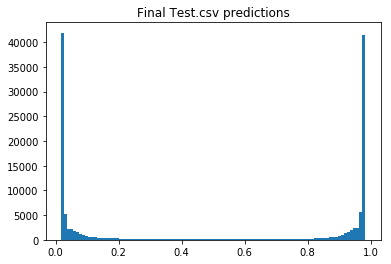

In [12]:
plt.hist(preds_stack_lr,bins=100)
plt.title('Final Test.csv predictions')
plt.show()

# sub = pd.read_csv('../input/sample_submission.csv')
# sub['target'] = preds_stack_lr
# sub.to_csv('submission.csv',index=False)